In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="6"

Sat Jan 13 22:22:35 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   25C    P8    13W / 230W |  17558MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 35%   

### Model Parts

In [3]:
from model.main.enc_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.latent_layer.uniform_lse_latent_layer import LatentLayer
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *


### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2
hp.h_dims = [32, 64, 128, 256, 512]

In [5]:
step = 0
device = 'cuda:0'

model = Model(Encoder(**hp), LatentLayer(**hp), Decoder(**hp))
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))
        
print('done')

encoder 6.004646301269531
encoder.convs 5.989013671875
encoder.linear 0.01563262939453125
latent_layer 0.0
decoder 6.044322967529297
decoder.linear 0.0234375
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train01.11-6/'
!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, net_g, _, opt_g, _ = load(save_dir, 0, model, optimizer)

total 0


### Dataset

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=128, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


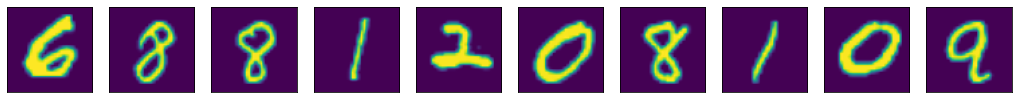

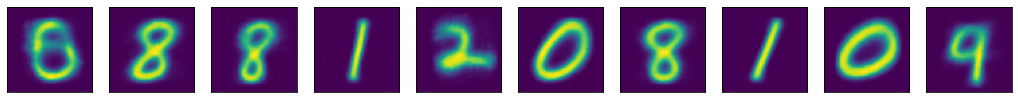

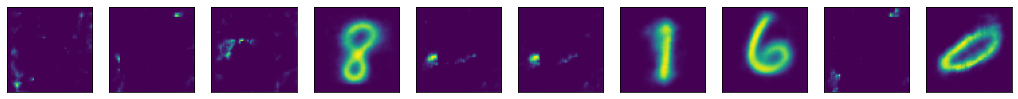

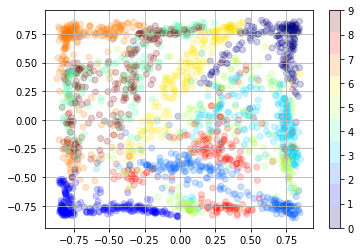

150001
lse_loss -1.3574162721633911
recon_loss 0.10880453884601593
150002
lse_loss -1.3950035572052002
recon_loss 0.1197633147239685
150003
lse_loss -1.368361234664917
recon_loss 0.12336361408233643
150004
lse_loss -1.3713653087615967
recon_loss 0.10805724561214447
150005
lse_loss -1.3539392948150635
recon_loss 0.11138676851987839
150006
lse_loss -1.3972443342208862
recon_loss 0.10682147741317749
150007
lse_loss -1.3508301973342896
recon_loss 0.11188780516386032
150008
lse_loss -1.3784151077270508
recon_loss 0.11296606063842773
150009
lse_loss -1.3877935409545898
recon_loss 0.12847331166267395
150010
lse_loss -1.3867864608764648
recon_loss 0.12699532508850098
150011
lse_loss -1.3680951595306396
recon_loss 0.11355046927928925
150012
lse_loss -1.3585458993911743
recon_loss 0.11958863586187363
150013
lse_loss -1.3931106328964233
recon_loss 0.1196388229727745
150014
lse_loss -1.389636754989624
recon_loss 0.12077920883893967
150015
lse_loss -1.3467495441436768
recon_loss 0.11429056525230408

150127
lse_loss -1.3495042324066162
recon_loss 0.12699496746063232
150128
lse_loss -1.3758809566497803
recon_loss 0.11510668694972992
150129
lse_loss -1.395694375038147
recon_loss 0.11367534846067429
150130
lse_loss -1.3557419776916504
recon_loss 0.12449919432401657
150131
lse_loss -1.3777178525924683
recon_loss 0.11228291690349579
150132
lse_loss -1.36857008934021
recon_loss 0.12598690390586853
150133
lse_loss -1.3747059106826782
recon_loss 0.12242043018341064
150134
lse_loss -1.3696484565734863
recon_loss 0.11185668408870697
150135
lse_loss -1.3668748140335083
recon_loss 0.12455374002456665
150136
lse_loss -1.364405870437622
recon_loss 0.11449633538722992
150137
lse_loss -1.3780980110168457
recon_loss 0.11584606766700745
150138
lse_loss -1.3661686182022095
recon_loss 0.11407998204231262
150139
lse_loss -1.399450659751892
recon_loss 0.11822383105754852
150140
lse_loss -1.363956093788147
recon_loss 0.11211591213941574
150141
lse_loss -1.3469977378845215
recon_loss 0.11571361869573593
1

150252
lse_loss -1.3744641542434692
recon_loss 0.12180503457784653
150253
lse_loss -1.3559050559997559
recon_loss 0.11399459838867188
150254
lse_loss -1.37593412399292
recon_loss 0.11589592695236206
150255
lse_loss -1.3636293411254883
recon_loss 0.12167514860630035
150256
lse_loss -1.3754538297653198
recon_loss 0.11077378690242767
150257
lse_loss -1.3725650310516357
recon_loss 0.10802061855792999
150258
lse_loss -1.367496132850647
recon_loss 0.106312595307827
150259
lse_loss -1.3826072216033936
recon_loss 0.12476219981908798
150260
lse_loss -1.3656487464904785
recon_loss 0.1152486652135849
150261
lse_loss -1.3715590238571167
recon_loss 0.10705474019050598
150262
lse_loss -1.3862327337265015
recon_loss 0.11771928519010544
150263
lse_loss -1.3741780519485474
recon_loss 0.11310386657714844
150264
lse_loss -1.394113302230835
recon_loss 0.10904578864574432
150265
lse_loss -1.3763558864593506
recon_loss 0.11338441073894501
150266
lse_loss -1.3480010032653809
recon_loss 0.11826779693365097
15

150380
lse_loss -1.3755937814712524
recon_loss 0.129556804895401
150381
lse_loss -1.3762156963348389
recon_loss 0.11305605620145798
150382
lse_loss -1.3748222589492798
recon_loss 0.11329646408557892
150383
lse_loss -1.3636534214019775
recon_loss 0.11902236938476562
150384
lse_loss -1.398999810218811
recon_loss 0.11043473333120346
150385
lse_loss -1.3630142211914062
recon_loss 0.11983170360326767
150386
lse_loss -1.3726502656936646
recon_loss 0.1162564754486084
150387
lse_loss -1.377719521522522
recon_loss 0.12126579135656357
150388
lse_loss -1.378806471824646
recon_loss 0.11310780048370361
150389
lse_loss -1.366767168045044
recon_loss 0.12148337066173553
150390
lse_loss -1.378339409828186
recon_loss 0.1233336552977562
150391
lse_loss -1.367323875427246
recon_loss 0.11438949406147003
150392
lse_loss -1.3702363967895508
recon_loss 0.1212451159954071
150393
lse_loss -1.3678287267684937
recon_loss 0.11665447801351547
150394
lse_loss -1.3830626010894775
recon_loss 0.1155872493982315
150395


150505
lse_loss -1.3732224702835083
recon_loss 0.1264209747314453
150506
lse_loss -1.3869171142578125
recon_loss 0.12521857023239136
150507
lse_loss -1.3818691968917847
recon_loss 0.12943151593208313
150508
lse_loss -1.3756475448608398
recon_loss 0.12570607662200928
150509
lse_loss -1.3555797338485718
recon_loss 0.11184154450893402
150510
lse_loss -1.3800748586654663
recon_loss 0.10725241899490356
150511
lse_loss -1.377572774887085
recon_loss 0.12270208448171616
150512
lse_loss -1.363822340965271
recon_loss 0.11334900557994843
150513
lse_loss -1.3843215703964233
recon_loss 0.12225914001464844
150514
lse_loss -1.3629502058029175
recon_loss 0.11791237443685532
150515
lse_loss -1.3734809160232544
recon_loss 0.11797233670949936
150516
lse_loss -1.3714606761932373
recon_loss 0.12009704113006592
150517
lse_loss -1.3636150360107422
recon_loss 0.12670284509658813
150518
lse_loss -1.3610622882843018
recon_loss 0.10743448138237
150519
lse_loss -1.3742009401321411
recon_loss 0.11378364264965057
1

KeyboardInterrupt: 

In [10]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        data = preprocess(batch)
        
        # Forward
        model.train()
        model.zero_grad()
        data = model(data, M=1000, sigma=0.149)
        
        # Backward
        loss = 0
        for key in data.keys():
            if 'loss' in key:
                loss = loss + data[key]
                writer.add_scalar(key, data[key].item(), step)
                print(key, data[key].item())
        loss.backward()
        optimizer.step()
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model.eval()
            with torch.no_grad():
                data = model(data, M=1000, sigma=1e-1)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = torch.randn(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'), alpha=0.2)
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save(save_dir, step, model, optimizer)
                
        step += 1
        

In [ ]:
import matplotlib.pyplot as plt
display.clear_output()

batch = next(iter(test_loader))
data = preprocess(batch)

model.eval()
with torch.no_grad():
    data = model(data, M=1000, sigma=1e-1)

plot(data['x'])
plot(data['y'])

with torch.no_grad():
    z = torch.randn(10, hp.z_dim).to(device)
    y = model.sample(z)
    plot(y)

import matplotlib.pyplot as plt
_z = data['z'].data.cpu().numpy()
plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'), alpha=0.2)
plt.grid()
plt.colorbar()
plt.show()